# An experiment in computational statistical inference

This notebook is based on the notes and code in the
[Teaching statistical inference with resampling](https://github.com/AllenDowney/CompStats/blob/master/resampling.ipynb) notebook
by Allen Downey

In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

import numpy as np
import matplotlib.pyplot as plt

np.random.seed(4)

ERROR:root:The 'ast_node_interactivity' trait of a ZMQInteractiveShell instance must be any of ['all', 'last', 'last_expr', 'none'], but a value of 'last_expr_or_assign' <class 'str'> was specified.


The following function plots a histogram of a sequence of values:

In [14]:
def plot_hist(values, low=None, high=None):
    options = dict(alpha=0.5, color='C0')
    xs, ys, patches = plt.hist(values,
                               normed=True,
                               histtype='step', 
                               linewidth=3,
                               **options)
    
    
    plt.ylabel('Density')
    plt.tight_layout()
    return patches[0]

In [20]:
def fill_hist(low, high, patch):
    options = dict(alpha=0.5, color='C0')
    fill = plt.axvspan(low, high, 
                       clip_path=patch,
                       **options)

# My Experiment #

Following the "only one test" paradigm, I am going to play around with chi-squared like tests.

The problem will be the following from Wikipedia (https://en.wikipedia.org/wiki/Pearson%27s_chi-squared_test#Fairness_of_dice):

***

** Fairness of Dice **

A 6-sided dice is thrown 60 times. The number of times it lands with 1, 2, 3, 4, 5 and 6 face up is 5, 8, 9, 8, 10 and 20, respectively. Is the dice biased, according to the Pearson's chi-squared test at a significance level of 95% and/or 99%?

n = 6 as there are 6 possible outcomes, 1 to 6. The null hypothesis is that the dice is unbiased, hence each number is expected to occur the same number of times, in this case, 60/n = 10. 

***

Let me start with by defining some functions, similar to the example in Allen Downey's notebook

In [80]:
num_throws = 60

In [81]:
def roll(n):
    dice_rolls = np.random.randint(1,6+1,n)
    counts,_ = np.histogram(dice_rolls, bins=list(range(1,7+1)))
    return counts

In [82]:
# for example with n=60
roll(num_throws)

array([ 8, 15, 10, 13,  6,  8])

In [83]:
def run_dice_experiments(n,iters):
    t = [roll(n) for i in range(iters)]
    return np.array(t)

In [84]:
# for example, running with iters=10
outcomes = run_dice_experiments(num_throws,10000)

In [85]:
np.mean(outcomes,axis=0)

array([  9.9897,  10.0265,   9.9815,   9.9635,  10.0253,  10.0135])

In [86]:
expected = [num_throws/6 for i in range(6)]

In [87]:
diffs = outcomes-expected
diffs

array([[-1., -1.,  2.,  0.,  2., -2.],
       [ 1., -4., -3.,  1., -3.,  8.],
       [-1.,  2., -2., -2.,  0.,  3.],
       ..., 
       [ 0.,  0.,  3., -2., -2.,  1.],
       [ 1.,  4.,  1., -3.,  0., -3.],
       [ 2., -6.,  5.,  1., -5.,  3.]])

Now is where we have a few decisions. How do we quantify the differences between the observed and expected rolls. I am going to try two different methods.

- Sum of absolute differences. 

For example, lets say my rolls for each die (out of 60 total rolls) are:

observed = (5,8,9,8,10,20)

expected = (10,10,10,10,10,10)

sum_abs_diff = $sum(|5-10|,|8-10|,|9-10|,|8-10|,|10-10|,|20-10|) = sum(5,2,1,2,0,10) = 20$

- Chi-squared Statistic (uses squared differences) $\frac{(O_i-E_i)^2}{E_i}$:

Same as above, but square the differnce instead of taking the absolute value:

observed = (5,8,9,8,10,20)

expected = (10,10,10,10,10,10)

sum_squared_diff = $sum((5-10)^2/10,(8-10)^2/10,(9-10)^2/10,(8-10)^2/10,(10-10)^2/10,(20-10)^2/10) = sum(2.5,0.4,0.1,0.4,0.0,10) = 13.4$


In [88]:
sum_abs_diffs = np.sum(np.abs(diffs),axis=1)

In [89]:
chi_squared_diffs = np.sum((diffs**2)/(num_throws/6),axis=1)

Let's plot all of this now:

First let's do the ** sum of absolute deviations **

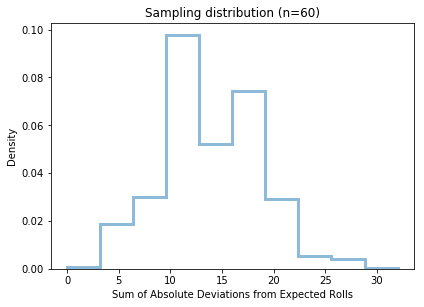

In [90]:
plot_hist(sum_abs_diffs)

plt.title('Sampling distribution (n=60)')
plt.xlabel('Sum of Absolute Deviations from Expected Rolls');

Now for the ** Chi-Squared**

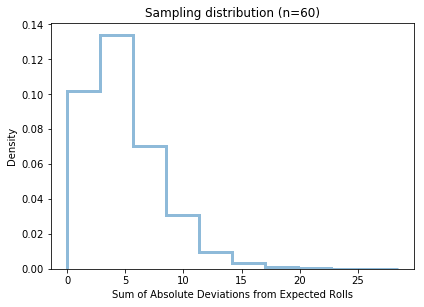

In [91]:
plot_hist(chi_squared_diffs)

plt.title('Sampling distribution (n=60)')
plt.xlabel('Sum of Absolute Deviations from Expected Rolls');

# find the p-values

In [92]:
observed = np.array([5,8,9,8,10,20])

In [93]:
observed_abs_diff = np.sum(np.abs(observed-expected))
observed_abs_diff

20.0

In [95]:
np.mean(sum_abs_diffs >= observed_abs_diff)

0.1246

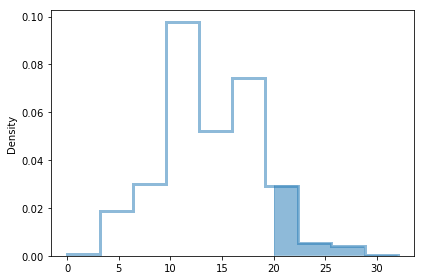

In [96]:
patch = plot_hist(sum_abs_diffs)

low = observed_abs_diff
high = np.max(sum_abs_diffs)
fill_hist(low, high, patch)

Now try it with chi-squared

In [99]:
observed_chi_squared_diff = np.sum(((observed-expected)**2)/(num_throws/6))
observed_chi_squared_diff

13.4

In [100]:
np.mean(chi_squared_diffs >= observed_chi_squared_diff)

0.0184

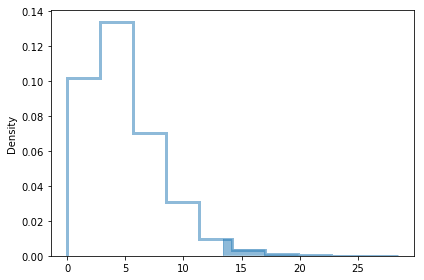

In [101]:
patch = plot_hist(chi_squared_diffs)

low = observed_chi_squared_diff
high = np.max(chi_squared_diffs)
fill_hist(low, high, patch)

So my respective p-values are 0.1246 and 0.0184, that's a somewhat large difference... Clearly, the squared term penalizes larger deviations from the expected values more, and thus this may be what causes the difference, since a 6 was rolled 20 times in our example.